<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/3_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Lesions Classifications using pretrained network VGG16

## Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
import os
import math
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Since in *CNN from scratch* the behaviour of the **Class Weight** approach to the problem of Unbalanced Classes was better, now on, we keep this one.

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/VGG"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Utility

In [ ]:
def compile_model(model, metrics='accuracy', loss='sparse_categorical_crossentropy', optimizer='adam', learning_rate = 0.001):
  '''
    compile_model is used to compile the current model
    :param model: model to compile
    :param optimizer: optimizer to be used
    :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    optimizer=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  else:
    return

  model.compile(loss=loss,
    optimizer=optimizer,
    metrics=[metrics])

  return model

def run_model (model, model_name, train_ds, val_ds, epochs=50, patience=3, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
           
  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks_list,
                    class_weight=class_weight
                    )
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  return tf.keras.models.load_model(save_path), history


def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight

# actually compute the CLASS WEIGHTS
labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

## Feature Extraction

Let's use the VGG16 as Feature Extractor.

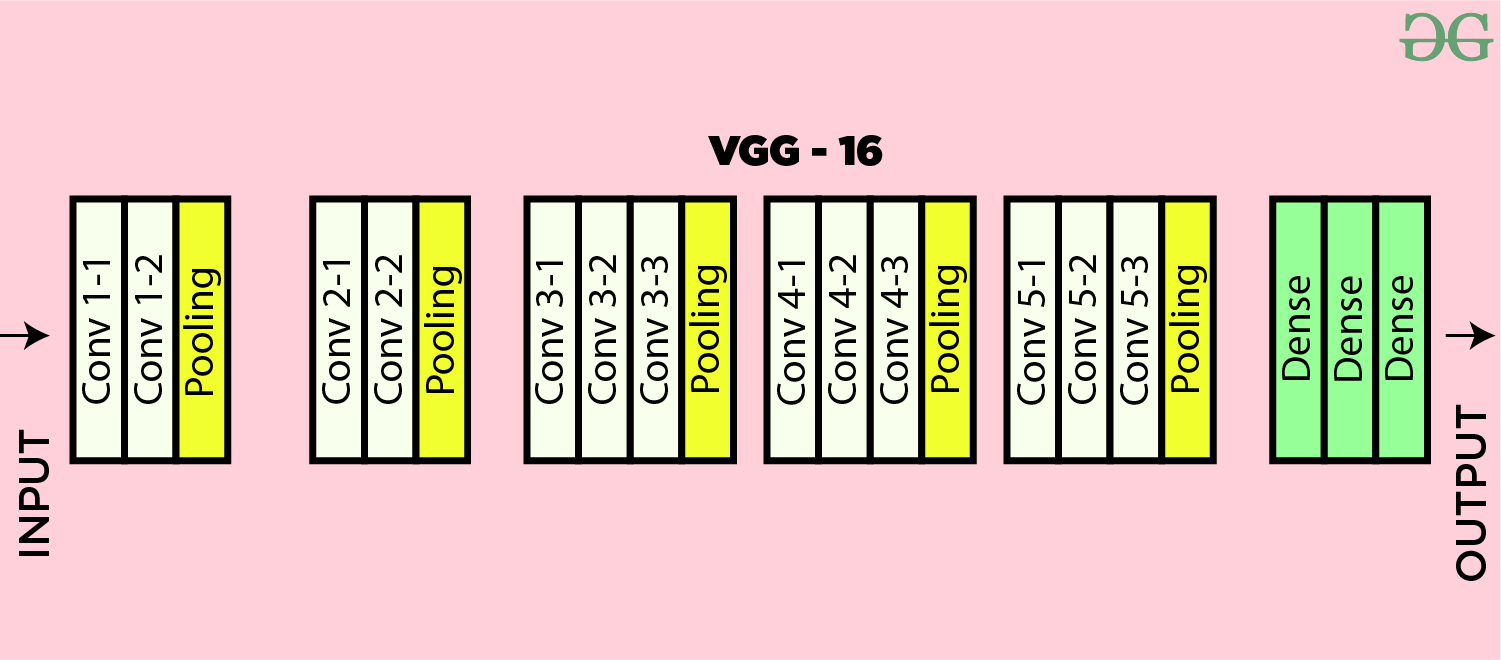

In [ ]:
vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)
)

vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###Dense

Di qualcosa a riguardo e di perché hai messo il global average pooling

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "Dense", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.6190 - accuracy: 0.6156 
Epoch 1: val_loss improved from inf to 0.87382, saving model to /content/models/Dense.h5
220/220 [==============================] - 3793s 17s/step - loss: 1.6190 - accuracy: 0.6156 - val_loss: 0.8738 - val_accuracy: 0.6927
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.7113
Epoch 2: val_loss did not improve from 0.87382
220/220 [==============================] - 45s 201ms/step - loss: 1.0404 - accuracy: 0.7114 - val_loss: 0.9301 - val_accuracy: 0.6453
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.8232 - accuracy: 0.7661
Epoch 3: val_loss improved from 0.87382 to 0.83442, saving model to /content/models/Dense.h5
220/220 [==============================] - 46s 204ms/step - loss: 0.8226 - accuracy: 0.7662 - val_loss: 0.8344 - val_accuracy: 0.7013
Epoch 4/50
220/220 [==============================] - ETA: 0s - loss: 0.6973 - a

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/Dense.h5')

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 782s 16s/step - loss: 0.7582 - accuracy: 0.7459
Loss on test set: 0.7581501007080078
Accuracy on test set: 0.745863676071167
                precision    recall  f1-score   support

       Actinic     0.3906    0.5000    0.4386        50
           BCC     0.5357    0.3750    0.4412        80
Dermatofibroma     0.2222    0.3333    0.2667        18
     Keratosis     0.4570    0.5120    0.4830       166
      Melanoma     0.5619    0.3512    0.4322       168
          Nevu     0.8674    0.8967    0.8818      1007
      Vascular     0.5938    0.8636    0.7037        22

      accuracy                         0.7459      1511
     macro avg     0.5184    0.5474    0.5210      1511
  weighted avg     0.7434    0.7459    0.7401      1511



In [ ]:
plot_confusionmatrix(model, test_images)

### Dense Layer and Dropout

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(DROPOUT)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "DenseDropout", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.8588 - accuracy: 0.5810
Epoch 1: val_loss improved from inf to 1.08840, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 647s 3s/step - loss: 1.8588 - accuracy: 0.5810 - val_loss: 1.0884 - val_accuracy: 0.6027
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 1.1780 - accuracy: 0.6808
Epoch 2: val_loss improved from 1.08840 to 1.04209, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 47s 211ms/step - loss: 1.1780 - accuracy: 0.6808 - val_loss: 1.0421 - val_accuracy: 0.5880
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 1.0139 - accuracy: 0.7103
Epoch 3: val_loss improved from 1.04209 to 0.86209, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 46s 208ms/step - loss: 1.0139 - accuracy: 0.7103 - val_loss: 0.8621 - val_accuracy: 0.6873
Epoch 4/50
220/2

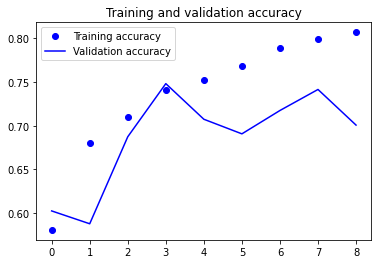

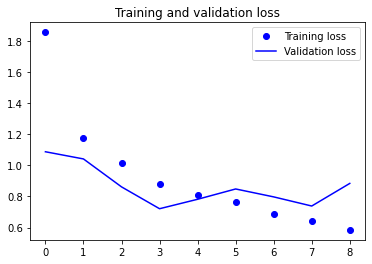

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 119s 2s/step - loss: 0.7282 - accuracy: 0.7432
Loss on test set: 0.7281774282455444
Accuracy on test set: 0.7432163953781128
                precision    recall  f1-score   support

       Actinic     0.4179    0.5600    0.4786        50
           BCC     0.4667    0.3500    0.4000        80
Dermatofibroma     0.2500    0.1667    0.2000        18
     Keratosis     0.4577    0.5542    0.5014       166
      Melanoma     0.5328    0.3869    0.4483       168
          Nevu     0.8733    0.8828    0.8780      1007
      Vascular     0.5806    0.8182    0.6792        22

      accuracy                         0.7432      1511
     macro avg     0.5113    0.5313    0.5122      1511
  weighted avg     0.7415    0.7432    0.7394      1511



48/48 [==============================] - 8s 173ms/step


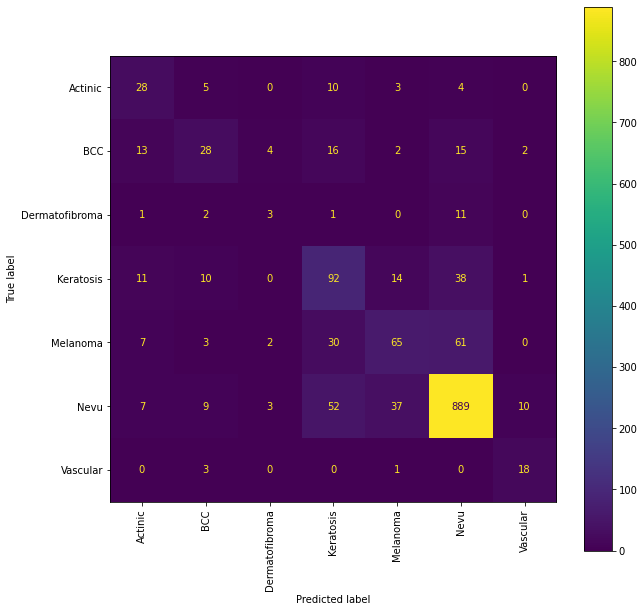

In [ ]:
plot_confusionmatrix(model, test_images)

## Fine Tuning

I decided to use the Dropout version considering the better performance.

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/DenseDropout.h5')

Now proceed to fine tune this architecture starting from the last layer.

### Last Layer

Note the usage of a smaller learning rate = 0.0001 because we are in Fine Tuning, instead during the previous phase in which we had the dense layer initialized with random weights the learning rate was 0.001.

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "FT_Last1", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.7468
Epoch 1: val_loss improved from inf to 0.73790, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 50s 218ms/step - loss: 0.8419 - accuracy: 0.7468 - val_loss: 0.7379 - val_accuracy: 0.7193
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8249
Epoch 2: val_loss did not improve from 0.73790
220/220 [==============================] - 48s 214ms/step - loss: 0.5524 - accuracy: 0.8249 - val_loss: 0.8404 - val_accuracy: 0.6847
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.8547
Epoch 3: val_loss did not improve from 0.73790
220/220 [==============================] - 48s 214ms/step - loss: 0.4315 - accuracy: 0.8547 - val_loss: 0.7425 - val_accuracy: 0.7387
Epoch 4/50
220/220 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8814
Epoch 4: val_loss improved f

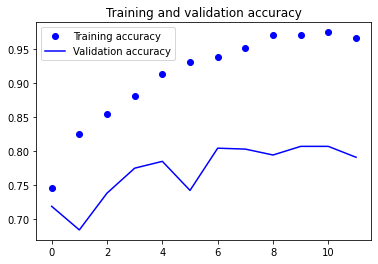

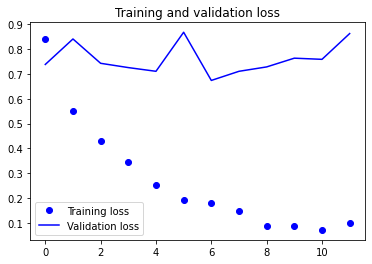

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 167ms/step - loss: 0.7041 - accuracy: 0.8034
Loss on test set: 0.7041295766830444
Accuracy on test set: 0.8034414052963257
                precision    recall  f1-score   support

       Actinic     0.6585    0.5400    0.5934        50
           BCC     0.6296    0.6375    0.6335        80
Dermatofibroma     0.4667    0.3889    0.4242        18
     Keratosis     0.6273    0.6084    0.6177       166
      Melanoma     0.5652    0.5417    0.5532       168
          Nevu     0.8956    0.9116    0.9035      1007
      Vascular     0.7037    0.8636    0.7755        22

      accuracy                         0.8034      1511
     macro avg     0.6495    0.6417    0.6430      1511
  weighted avg     0.7996    0.8034    0.8011      1511



48/48 [==============================] - 8s 173ms/step


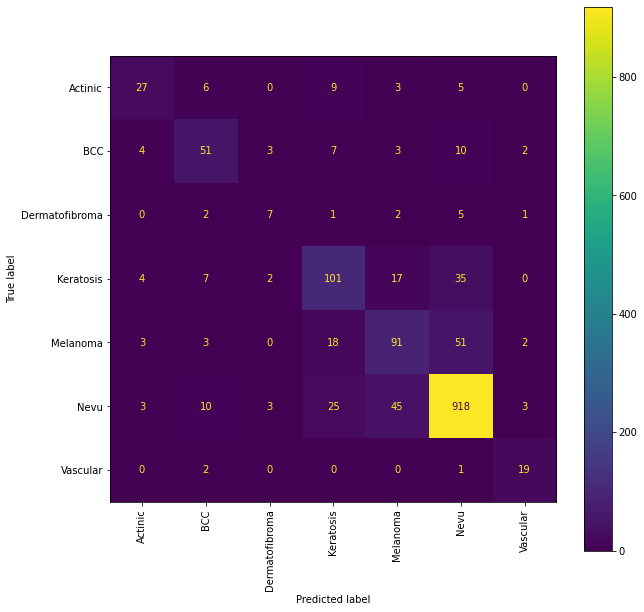

In [ ]:
plot_confusionmatrix(model, test_images)

### Last 2 Layers

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/DenseDropout.h5')

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "FT_Last2", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.7290
Epoch 1: val_loss improved from inf to 0.93866, saving model to /content/models/FT_Last2.h5
220/220 [==============================] - 51s 225ms/step - loss: 0.9902 - accuracy: 0.7290 - val_loss: 0.9387 - val_accuracy: 0.6433
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.8017
Epoch 2: val_loss improved from 0.93866 to 0.66237, saving model to /content/models/FT_Last2.h5
220/220 [==============================] - 49s 219ms/step - loss: 0.6383 - accuracy: 0.8017 - val_loss: 0.6624 - val_accuracy: 0.7833
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8493
Epoch 3: val_loss did not improve from 0.66237
220/220 [==============================] - 50s 223ms/step - loss: 0.4588 - accuracy: 0.8493 - val_loss: 0.6874 - val_accuracy: 0.7727
Epoch 4/50
220/220 [==============================] - ETA: 0s - loss: 0.322

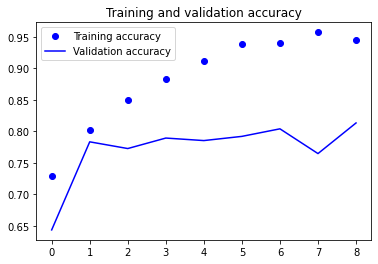

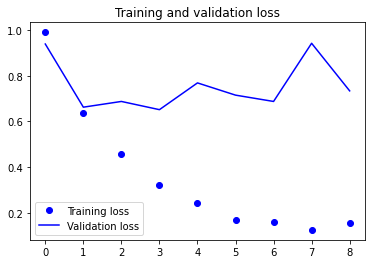

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 164ms/step - loss: 0.6526 - accuracy: 0.7935
Loss on test set: 0.6526245474815369
Accuracy on test set: 0.7935142517089844
                precision    recall  f1-score   support

       Actinic     0.8095    0.3400    0.4789        50
           BCC     0.5408    0.6625    0.5955        80
Dermatofibroma     0.5625    0.5000    0.5294        18
     Keratosis     0.6282    0.5904    0.6087       166
      Melanoma     0.4975    0.5952    0.5420       168
          Nevu     0.9065    0.8957    0.9011      1007
      Vascular     0.8333    0.9091    0.8696        22

      accuracy                         0.7935      1511
     macro avg     0.6826    0.6418    0.6465      1511
  weighted avg     0.8027    0.7935    0.7940      1511



48/48 [==============================] - 8s 168ms/step


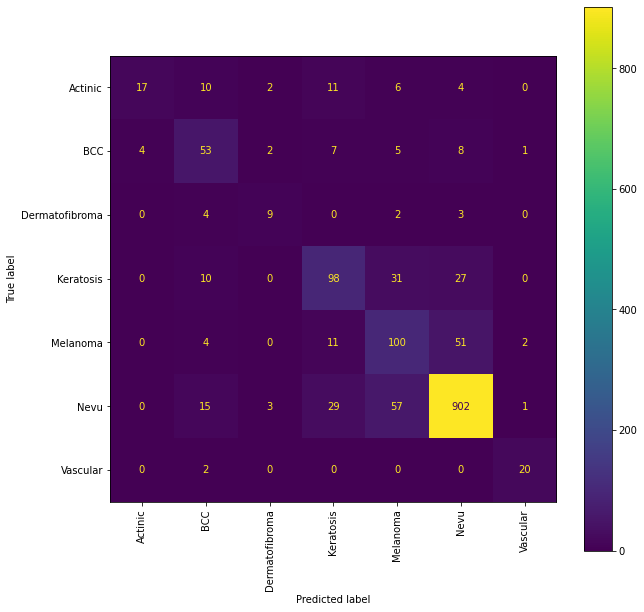

In [ ]:
plot_confusionmatrix(model, test_images)

### Last Block

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/DenseDropout.h5')

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "FT_LastBlock", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.1430 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 0.74161, saving model to /content/models/FT_LastBlock.h5
220/220 [==============================] - 53s 236ms/step - loss: 1.1430 - accuracy: 0.6933 - val_loss: 0.7416 - val_accuracy: 0.7353
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7762
Epoch 2: val_loss did not improve from 0.74161
220/220 [==============================] - 50s 223ms/step - loss: 0.7209 - accuracy: 0.7762 - val_loss: 0.7467 - val_accuracy: 0.7253
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.8340
Epoch 3: val_loss improved from 0.74161 to 0.60805, saving model to /content/models/FT_LastBlock.h5
220/220 [==============================] - 52s 234ms/step - loss: 0.5138 - accuracy: 0.8340 - val_loss: 0.6081 - val_accuracy: 0.8040
Epoch 4/50
220/220 [==============================] - ETA: 0s - los

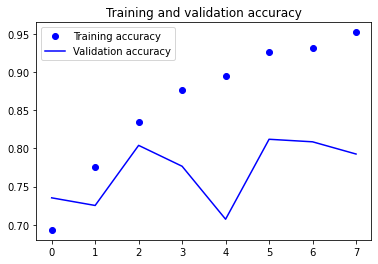

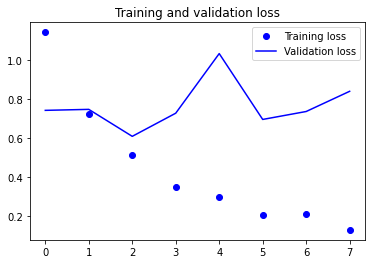

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 170ms/step - loss: 0.6369 - accuracy: 0.8001
Loss on test set: 0.63688063621521
Accuracy on test set: 0.8001323342323303
                precision    recall  f1-score   support

       Actinic     0.5345    0.6200    0.5741        50
           BCC     0.5758    0.7125    0.6369        80
Dermatofibroma     0.5333    0.4444    0.4848        18
     Keratosis     0.5708    0.7289    0.6402       166
      Melanoma     0.5714    0.5000    0.5333       168
          Nevu     0.9281    0.8838    0.9054      1007
      Vascular     0.8571    0.8182    0.8372        22

      accuracy                         0.8001      1511
     macro avg     0.6530    0.6726    0.6588      1511
  weighted avg     0.8117    0.8001    0.8037      1511



48/48 [==============================] - 8s 168ms/step


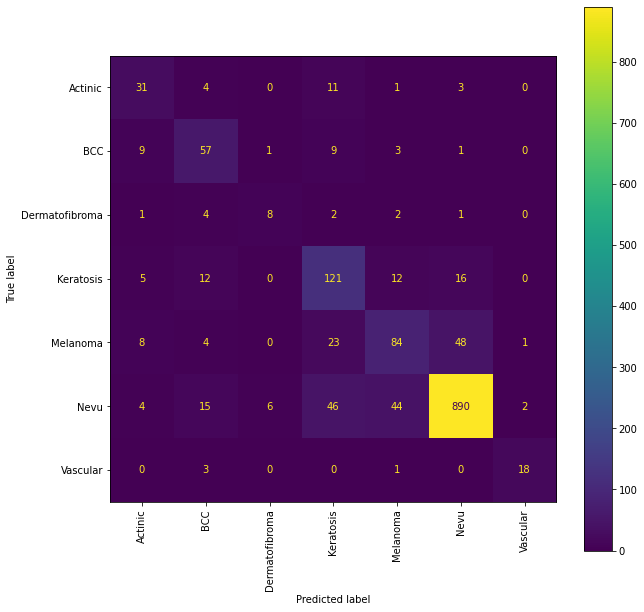

In [ ]:
plot_confusionmatrix(model, test_images)

###Train all blocks

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/DenseDropout.h5')

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
  layer.trainable = True

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.00001)
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [ ]:
model, history = run_model(model, "FT_Whole", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.7702
Epoch 1: val_loss improved from inf to 0.65840, saving model to /content/models/FT_Whole.h5
220/220 [==============================] - 117s 508ms/step - loss: 0.7975 - accuracy: 0.7702 - val_loss: 0.6584 - val_accuracy: 0.7587
Epoch 2/50
220/220 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.8117
Epoch 2: val_loss did not improve from 0.65840
220/220 [==============================] - 110s 499ms/step - loss: 0.5783 - accuracy: 0.8117 - val_loss: 0.7083 - val_accuracy: 0.7460
Epoch 3/50
220/220 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8492
Epoch 3: val_loss improved from 0.65840 to 0.64671, saving model to /content/models/FT_Whole.h5
220/220 [==============================] - 110s 499ms/step - loss: 0.4422 - accuracy: 0.8492 - val_loss: 0.6467 - val_accuracy: 0.7667
Epoch 4/50
220/220 [==============================] - ETA: 0s - loss: 0.

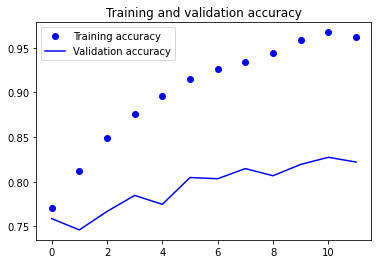

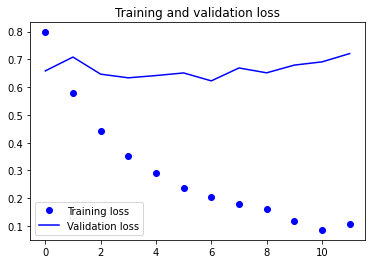

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 8s 169ms/step - loss: 0.6945 - accuracy: 0.8015
Loss on test set: 0.6945327520370483
Accuracy on test set: 0.8014559745788574
                precision    recall  f1-score   support

       Actinic     0.5254    0.6200    0.5688        50
           BCC     0.6618    0.5625    0.6081        80
Dermatofibroma     0.4000    0.4444    0.4211        18
     Keratosis     0.6352    0.6084    0.6215       166
      Melanoma     0.5440    0.5893    0.5657       168
          Nevu     0.9170    0.8997    0.9083      1007
      Vascular     0.6000    0.9545    0.7368        22

      accuracy                         0.8015      1511
     macro avg     0.6119    0.6684    0.6329      1511
  weighted avg     0.8073    0.8015    0.8033      1511



48/48 [==============================] - 8s 167ms/step


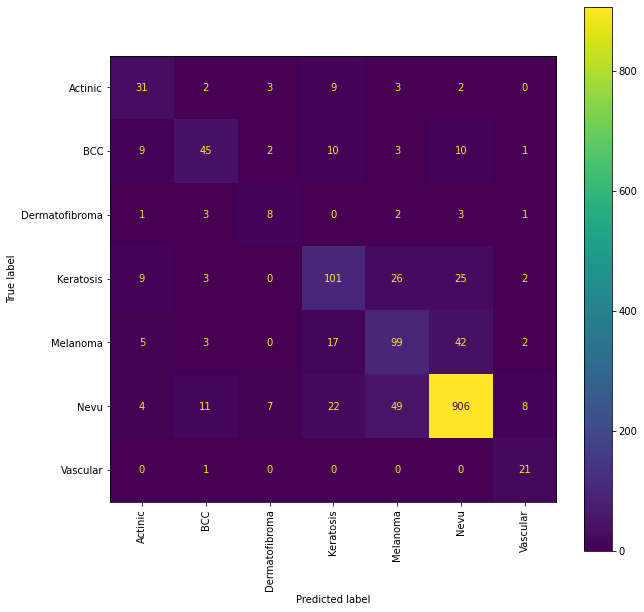

In [ ]:
plot_confusionmatrix(model, test_images)